In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  
sys.path.insert(1, '/data/pku/home/licq/cH/zz_v2/selection/analyzer')

# os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
from glob import glob
fileset = {
    'ggH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/GluGluHToZZTo4L_M125_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8/merged.root'],
    'HC_3FS': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/HPlusCharm_3FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/merged.root'],
    'HC_4FS': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/merged.root'],
    'HC_4FSFxFx': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnloFXFX_JHUGenV7011_pythia8/merged.root'],
    'ggZZTo4e': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8/merged.root'],
    'ggZZTo4mu': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8/merged.root'],
    'ggZZTo4tau': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8/merged.root'],
    'ggZZTo2e2mu': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8/merged.root'],
    'ggZZTo2e2tau': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8/merged.root'],
    'ggZZTo2mu2tau': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8/merged.root'],
    'qqZZ': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/*/*/*/*.root'),
    'ttH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext2/ttH_HToZZ_4LFilter_M125_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8/merged.root'],
    'bbH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext2/bbH_HToZZTo4L_M125_TuneCP2_13TeV-jhugenv7011-pythia8/merged.root'],
    'tqH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext2/tqH_HToZZTo4L_M125_TuneCP5_13TeV-jhugenv7011-pythia8/merged.root'],
    'WminusH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext2/WminusH_HToZZTo4L_M125_TuneCP5_13TeV_powheg2-minlo-HWJ_JHUGenV7011_pythia8/merged.root'],
    'WplusH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext2/WplusH_HToZZTo4L_M125_TuneCP5_13TeV_powheg2-minlo-HWJ_JHUGenV7011_pythia8/merged.root'],
    'ZH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext2/ZH_HToZZ_4LFilter_M125_TuneCP5_13TeV_powheg2-minlo-HZJ_JHUGenV7011_pythia8/merged.root'],
    'VBFH': ['/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext2/VBF_HToZZTo4L_M125_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8/merged.root'],
    'ZX':  ['/home/pku/licq/cH/zz_v2/selection/notebooks/coffea_output/ZX_1.root'],
}
plot_info = { # order is important
    'HC_4FSFxFx':   (['HC_4FSFxFx'], 'H+c $(\kappa_c=%d)$', 'red'),
    'HC_4FS':   (['HC_4FS'], 'H+c (4FS) $(\kappa_c=%d)$', 'violet'),
    'HC_3FS':   (['HC_3FS'], 'H+c (3FS) $(\kappa_c=%d)$', 'blueviolet'),
    'ggH':  (['ggH'], r'$gg\to H$', 'lightpink'),
    'VBFH': (['VBFH'], r'EW $qqH$', 'thistle'),
    'WH':   (['WminusH', 'WplusH'], r'$WH$', 'hotpink'),
    'ZH':   (['ZH'], r'$ZH$', 'deeppink'),
    'ttH':  (['ttH'], r'$t\bar{t}H$', 'violet'),
    'bbH':  (['bbH'], r'$b\bar{b}H$', 'mediumorchid'),
    'tqH':  (['tqH'], r'$tqH$', 'darkviolet'),
    'qqZZ': (['qqZZ'], r'$q\bar{q}\to ZZ,\,Z\gamma*$', 'lightskyblue'),
    'ggZZ': (['ggZZTo4e', 'ggZZTo4mu', 'ggZZTo4tau', 'ggZZTo2e2mu', 'ggZZTo2e2tau', 'ggZZTo2mu2tau'], r'$gg\to ZZ,\,Z\gamma*$', 'royalblue'),
    'ZX':   (['ZX'], 'Z+X', 'green'),
}

# BDT vars
train_vars_base = [
 'H_pt',
 'H_eta',
]
train_vars_sv = [
 'cleanedsv_leadc2c_pt',
 'cleanedsv_leadc2c_eta',
 'cleanedsv_leadc2c_mass',
 'cleanedsv_leadc2c_H_ptrel',
 'cleanedsv_leadc2c_H_deta',
 'cleanedsv_leadc2c_H_dphi',
 'cleanedsv_leadc2c_H_dr',
 'cleanedsv_leadc2c_H_mass',
 'cleanedsv_leadc2c_Z1_ptrel',
 'cleanedsv_leadc2c_Z1_deta',
 'cleanedsv_leadc2c_Z1_dphi',
 'cleanedsv_leadc2c_Z1_dr',
 'cleanedsv_leadc2c_Z1_mass',
 'cleanedsv_leadc2c_Z2_ptrel',
 'cleanedsv_leadc2c_Z2_deta',
 'cleanedsv_leadc2c_Z2_dphi',
 'cleanedsv_leadc2c_Z2_dr',
 'cleanedsv_leadc2c_Z2_mass',
]
train_vars_jet = [
 'cleanedjet_leadc2c_pt',
 'cleanedjet_leadc2c_eta',
 'cleanedjet_leadc2c_mass',
 'cleanedjet_leadc2c_H_ptrel',
 'cleanedjet_leadc2c_H_deta',
 'cleanedjet_leadc2c_H_dphi',
 'cleanedjet_leadc2c_H_dr',
 'cleanedjet_leadc2c_H_mass',
 'cleanedjet_leadc2c_Z1_ptrel',
 'cleanedjet_leadc2c_Z1_deta',
 'cleanedjet_leadc2c_Z1_dphi',
 'cleanedjet_leadc2c_Z1_dr',
 'cleanedjet_leadc2c_Z1_mass',
 'cleanedjet_leadc2c_Z2_ptrel',
 'cleanedjet_leadc2c_Z2_deta',
 'cleanedjet_leadc2c_Z2_dphi',
 'cleanedjet_leadc2c_Z2_dr',
 'cleanedjet_leadc2c_Z2_mass',
]

lumi = 59.83 * 1e3

import pickle
with open('coffea_output/sumw.pkl', 'rb') as f:
    sumw = pickle.load(f)
# sumw = {'qqZZ': sumw['qqZZ']}
# for sam in fileset:
#     print(sam)
#     if sam != 'ZX' and sam != 'qqZZ':
#         sumw[sam] = sum([uproot.open(f+':Ana/sumWeights').to_numpy()[0][0] for f in fileset[sam]])
# import pickle
# with open('coffea_output/sumw.pkl', 'wb') as f:
#     pickle.dump(sumw, f)

for cat in ['ggH', 'HC_3FS', 'HC_4FS', 'HC_4FSFxFx']:
    sumw[f'{cat}_l'] = sumw[f'{cat}_c'] = sumw[f'{cat}_b'] = sumw[cat]

# Coffea processor

In [8]:
from coffea import processor, hist
from functools import partial
from importlib import reload
import plotter, cutflow, ntupler
make_plot_flv = reload(plotter).make_plot_flv
recon_cleaned_jet = reload(cutflow).recon_cleaned_jet
recon_cleaned_sv = reload(cutflow).recon_cleaned_sv
recon_jet_sv_candidate = reload(cutflow).recon_jet_sv_candidate
ntupler = reload(ntupler).ntupler
from xgb_tools import XGBEnsemble

class H4lPlusCharmProcessor(processor.ProcessorABC):
    def __init__(self, input_dict, selection_expr=None, do_reco=False, do_bdt_infer=False, accumulate_column=False):
        dataset = hist.Cat("dataset", "dataset")

        self.input_dict = input_dict
        self.selection_expr = selection_expr
        self.do_reco = do_reco
        self.do_bdt_infer = do_bdt_infer
        self.accumulate_column = accumulate_column

        self._accumulator = processor.dict_accumulator({
            # defination of cutflow (nested dictionary of int) copied from the example
            'cutflow': processor.defaultdict_accumulator(
                partial(processor.defaultdict_accumulator, int)
            ),
        })

        # initiate histograms
        for var, (_, nbin, xmin, xmax) in input_dict.items():
            bin = hist.Bin('var', 'label', nbin) if isinstance(nbin, list) else hist.Bin('var', 'label', nbin, xmin, xmax)
            self._accumulator[var] = hist.Hist('Counts', dataset, bin)
    
        self.make_2d = True if len(input_dict) >= 2 else False
        if self.make_2d:
            varx, (_, nbinx, xminx, xmaxx) = list(input_dict.items())[0]
            vary, (_, nbiny, xminy, xmaxy) = list(input_dict.items())[1]
            binx = hist.Bin('varx', 'label', nbinx) if isinstance(nbinx, list) else hist.Bin('varx', 'label', nbinx, xminx, xmaxx)
            biny = hist.Bin('vary', 'label', nbiny) if isinstance(nbiny, list) else hist.Bin('vary', 'label', nbiny, xminy, xmaxy)
            self._accumulator['2D'] = hist.Hist('Counts', dataset, binx, biny)

        # initiate column accumulator
        if self.accumulate_column:
            self._accumulator['column'] = processor.defaultdict_accumulator(
                partial(processor.defaultdict_accumulator, # dataset
                    partial(processor.column_accumulator, np.array([], dtype=np.float32)) # vars
                )
            )
        
        # initiate xgboost
        if self.do_bdt_infer:
            self.xgb_1j = XGBEnsemble(
                ['/home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.%d' % i for i in range(5)],
                train_vars_base + train_vars_jet,
            )
            self.xgb_0j = XGBEnsemble(
                ['/home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jet0_svge1/xgb_train.model.%d' % i for i in range(5)],
                train_vars_base + train_vars_sv,
            )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        out = self.accumulator.identity()
        dataset = df.metadata['dataset']
        # out['cutflow'][dataset]['all'] += len(df)
        # out['cutflow'][dataset]['sumw_pass'] += ak.sum(df.eventWeight)

        if dataset != 'ZX':
            df = df[df.passedFullSelection]

        class dotdict(dict):
            __getattr__ = dict.get
            __setattr__ = dict.__setitem__
            __delattr__ = dict.__delitem__

        dfext = dotdict()
        if self.do_reco:
            recon_cleaned_jet(df, dfext)
            recon_cleaned_sv(df, dfext)
            recon_jet_sv_candidate(df, dfext)
        if self.do_bdt_infer:
            dfbdt = ntupler(df, is_hc=dataset.startswith('HC_'), store_gen=False, store_pfcands=False, store_flat_only=True)
            # print(dfbdt['cleanedjet_leadc2c_pt'])
            dfext['bdt_1j'] = ak.Array(self.xgb_1j.eval({k: dfbdt[k] for k in self.xgb_1j.var_list}))
            dfext['bdt_0j'] = ak.Array(self.xgb_0j.eval({k: dfbdt[k] for k in self.xgb_0j.var_list}))
            dfext['bdt_1j'] = dfext['bdt_1j'].mask[~ak.is_none(dfext.jet_cand)]
            dfext['bdt_0j'] = dfext['bdt_0j'].mask[~ak.is_none(dfext.sv_cand)]

        import numpy as np
        if self.selection_expr is not None:
            selection = eval(self.selection_expr)
            df = df[selection]
            for b in dfext:
                dfext[b] = dfext[b][selection]

        # print("Number of events: ", len(dfext.jet_cand))
        # print(">=1 jet: ", ak.sum(~ak.is_none(dfext.jet_cand)))
        # print("Candidate jet has a matched SV: ", ak.sum(~ak.is_none(dfext.sv_cand_closest)))
        # print(">=1 SV: ", ak.sum(~ak.is_none(dfext.sv_cand)))
        # print("No jet but >=1 SV: ", ak.sum((ak.is_none(dfext.jet_cand)) & (~ak.is_none(dfext.sv_cand))))

        if dataset != 'ZX':
            weight = df.eventWeight
        else:
            weight = df.ZXWeight * df.ZXFileWeight
            # additional change
            ext_weight = ((abs(dfext.lep.id[:, 0])==11) & (abs(dfext.lep.id[:, 1])==11) & (abs(dfext.lep.id[:, 2])==11) & (abs(dfext.lep.id[:, 3])==11)) * 0.7851 + \
                        ((abs(dfext.lep.id[:, 0])==13) & (abs(dfext.lep.id[:, 1])==13) & (abs(dfext.lep.id[:, 2])==13) & (abs(dfext.lep.id[:, 3])==13)) * 0.6012 + \
                        ((abs(dfext.lep.id[:, 0])==11) & (abs(dfext.lep.id[:, 1])==11) & (abs(dfext.lep.id[:, 2])==13) & (abs(dfext.lep.id[:, 3])==13)) * 0.7467 + \
                        ((abs(dfext.lep.id[:, 0])==13) & (abs(dfext.lep.id[:, 1])==13) & (abs(dfext.lep.id[:, 2])==11) & (abs(dfext.lep.id[:, 3])==11)) * 0.4034
            weight = weight * ext_weight

        if dataset in ['ggH', 'HC_3FS', 'HC_4FS', 'HC_4FSFxFx']:
            genflv = ak.fill_none(ak.values_astype(ak.max(df.GENjet_hadronFlavour, axis=1), 'int'), 0)

        ## Fill histograms
        for var, (content_expr, *_) in self.input_dict.items():

            out[var].fill(
                dataset=dataset,
                var=eval(content_expr),
                weight=weight,
            )
            if self.make_2d and var == list(self.input_dict.keys())[0]:
                _, (content_exprx, *_) = list(self.input_dict.items())[0]
                _, (content_expry, *_) = list(self.input_dict.items())[1]
                out['2D'].fill(
                    dataset=dataset,
                    varx=eval(content_exprx),
                    vary=eval(content_expry),
                    weight=weight,
                )
            if dataset in ['ggH', 'HC_3FS', 'HC_4FS', 'HC_4FSFxFx']:
                # GEN flavour for ggH and HC
                for gf, gf_lab in zip([0, 4, 5], 'lcb'):
                    out[var].fill(
                        dataset=dataset + '_' + gf_lab,
                        var=eval(content_expr)[genflv == gf],
                        weight=weight[genflv == gf],
                    )
                    if self.make_2d and var == list(self.input_dict.keys())[0]:
                        _, (content_exprx, *_) = list(self.input_dict.items())[0]
                        _, (content_expry, *_) = list(self.input_dict.items())[1]
                        out['2D'].fill(
                            dataset=dataset + '_' + gf_lab,
                            varx=eval(content_exprx)[genflv == gf],
                            vary=eval(content_expry)[genflv == gf],
                            weight=weight[genflv == gf],
                        )
            
        
        # Accumulate columns
        if self.accumulate_column:
            for var, (content_expr, *_) in self.input_dict.items():
                out['column'][dataset][var] += processor.column_accumulator(ak.to_numpy(eval(content_expr)).astype(np.float32))
            out['column'][dataset]['weight'] += processor.column_accumulator(ak.to_numpy(weight).astype(np.float32))

            if dataset in ['ggH', 'HC_3FS', 'HC_4FS', 'HC_4FSFxFx']:
                for gf, gf_lab in zip([0, 4, 5], 'lcb'):
                    for var, (content_expr, *_) in self.input_dict.items():
                        out['column'][dataset + '_' + gf_lab][var] += processor.column_accumulator(ak.to_numpy(eval(content_expr)[genflv == gf]).astype(np.float32))
                    out['column'][dataset + '_' + gf_lab]['weight'] += processor.column_accumulator(ak.to_numpy(weight[genflv == gf]).astype(np.float32))

        return out

    def postprocess(self, accumulator):
        return accumulator

# Make plots

In [4]:
def make_plot(
    title, nbin, xmin, xmax, content_expr='df.mass4l', selection_expr=None,
    do_coffea=True, coffea_run_fileset='all', coffea_kwargs={},
    do_flv_mode=False,
    xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', ylog=False, custom_command=None, store_plot=False):

    # First run coffea to fill histogram
    global result
    if do_coffea:
        result = processor.run_uproot_job(
            fileset=fileset if coffea_run_fileset == 'all' else {s: fileset[s] for s in coffea_run_fileset},
            treename="Ana/passedEvents",
            processor_instance=H4lPlusCharmProcessor(
                {title: (content_expr, nbin, xmin, xmax)},
                selection_expr=selection_expr, **coffea_kwargs
            ),
            executor=processor.futures_executor,
            executor_args={"schema": BaseSchema, "workers": 30},
        )

    # Make plots
    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

    plot_bkg_info = {k: v for k, v in plot_info.items() if not k.startswith('HC_')}
    plot_sig_info = {k: v for k, v in plot_info.items() if k.startswith('HC_')}
    if coffea_run_fileset != 'all':
        for cat, (samlist, _, _) in plot_bkg_info.copy().items():
            if any(s not in coffea_run_fileset for s in samlist):
                del plot_bkg_info[cat]
        for cat, (samlist, _, _) in plot_sig_info.copy().items():
            if any(s not in coffea_run_fileset for s in samlist):
                del plot_sig_info[cat]

    if do_flv_mode:
        def color_fader(c1, c2, mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
            mix = min(1., mix)
            c1=np.array(mpl.colors.to_rgb(c1))
            c2=np.array(mpl.colors.to_rgb(c2))
            return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
        _plot_bkg_info = {
            'HC_4FSFxFx_l':   (['HC_4FSFxFx_l'], 'H+c (l) $(\kappa_c=1)$', color_fader('red', 'yellow', 0.2)),
            'HC_4FSFxFx_c':   (['HC_4FSFxFx_c'], 'H+c (c) $(\kappa_c=1)$', color_fader('red', 'black', 0.02)),
            'HC_4FSFxFx_b':   (['HC_4FSFxFx_b'], 'H+c (b) $(\kappa_c=1)$', color_fader('red', 'blue', 0.2)),
        }
        for cat in plot_bkg_info:
            if cat == 'ggH':
                _plot_bkg_info.update({
                    'ggH_l':  (['ggH_l'], r'$gg\to H$ (l)', color_fader('lightpink', 'yellow', 0.2)),
                    'ggH_c':  (['ggH_c'], r'$gg\to H$ (c)', color_fader('lightpink', 'black', 0.02)),
                    'ggH_b':  (['ggH_b'], r'$gg\to H$ (b)', color_fader('lightpink', 'blue', 0.2)),
                })
            else:
                _plot_bkg_info[cat] = plot_bkg_info[cat]
        plot_bkg_info = _plot_bkg_info
        plot_sig_info = {}

    histkey = list(plot_bkg_info.keys())[::-1]
    # get weighted boost histogram
    hist = {}
    print(plot_bkg_info, plot_sig_info)
    for cat, (samlist, _, _) in {**plot_bkg_info, **plot_sig_info}.items():
        _h = []
        for sam in samlist:
            scale = (lumi / sumw[sam]) if sam != 'ZX' else 1.
            _h.append(result[title][sam].project('var').to_boost() * scale)
        hist[cat] = sum(_h)

    hist_add = sum([hist[cat] for cat in plot_bkg_info.keys()])

    # make stacked plot
    if len(plot_bkg_info) > 0:
        hep.histplot(
            [hist[k].view().value for k in histkey], 
            bins=hist_add.axes[0].edges,
            yerr=[np.sqrt(hist[k].view().variance) for k in histkey],
            label=[plot_bkg_info[k][1] + ' (%.2f)'%sum(hist[k].view().value) for k in histkey], color=[plot_bkg_info[k][2] for k in histkey], 
            histtype='fill', edgecolor='k', linewidth=1, stack=True,
        )

        # plot signal stat uncertainties
        bkgtot, bkgtot_err = hist_add.view(flow=False).value, np.sqrt(hist_add.view(flow=False).variance)
        ax.fill_between(hist_add.axes[0].edges, (bkgtot-bkgtot_err).tolist()+[0], (bkgtot+bkgtot_err).tolist()+[0], label='BKG stat. unce.', step='post', hatch='///', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

    # plot signal
    kc = 10
    for cat in plot_sig_info:
        hep.histplot(
            hist[cat].view().value * kc**2,
            bins=hist[cat].axes[0].edges,
            yerr=np.sqrt(hist[cat].view().variance) * kc**2,
            label=plot_sig_info[cat][1] % kc, color=plot_sig_info[cat][2], 
        )
#         print('sig', hist[samsig].view().value, 'bkgtot', hist_add.view().value, np.sqrt(2*np.sqrt(hist_add.view().value[0]) / hist[samsig].view().value[0]))

    ax.legend(prop={'size': 18}, ncol=2, labelspacing=0.2, borderpad=0.3)
    ax.set_xlabel(xlabel, ha='right', x=1.0); ax.set_ylabel(ylabel, ha='right', y=1.0);
    
    ax.set_xlim(xmin, xmax); ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if ylog:
        ax.set_yscale('log')
    if custom_command is not None:
        exec(custom_command)
    
    if store_plot:
        store_dir = '../plots/histo_230216/'
        plt.savefig(store_dir + f'/{title}.jpg')
        plt.savefig(store_dir + f'/{title}.pdf')



# Skimmer

In [5]:
def ntuple_skimmer(
    title,
    varx, nbinx, xminx, xmaxx, content_exprx,
    vary, nbiny, xminy, xmaxy, content_expry,
    selection_expr=None,
    do_coffea=True, coffea_run_fileset='all', coffea_input_dict=None, coffea_kwargs={},
    ):

    # 1. Run coffea to fill histogram
    global result
    if do_coffea:
        result = processor.run_uproot_job(
            fileset=fileset if coffea_run_fileset == 'all' else {s: fileset[s] for s in coffea_run_fileset},
            treename="Ana/passedEvents",
            processor_instance=H4lPlusCharmProcessor(
                {varx: (content_exprx, nbinx, xminx, xmaxx),
                 vary: (content_expry, nbiny, xminy, xmaxy)} if coffea_input_dict is None else coffea_input_dict,
                selection_expr=selection_expr, accumulate_column=True,
                **coffea_kwargs
            ),
            executor=processor.futures_executor,
            executor_args={"schema": BaseSchema, "workers": 30},
        )

    os.makedirs(f"../fitspace/{title}/arrays", exist_ok=True)

    # Write arrays
    store_info = plot_info.copy()
    if coffea_run_fileset != 'all':
        # remove categories that are not run with coffea
        for cat, (samlist, _, _) in store_info.copy().items():
            if any(s not in coffea_run_fileset for s in samlist):
                del store_info[cat]
    if 'ggH' in store_info:
        store_info.update({f'ggH_{fl}': ([f'ggH_{fl}'], r'$gg\to H$ (%s)' % fl, None) for fl in 'lcb'})
    if 'HC_4FSFxFx' in store_info:
        store_info.update({f'HC_4FSFxFx_{fl}': ([f'HC_4FSFxFx_{fl}'], r'H+c (%s) $(\kappa_c=1)$' % fl, None) for fl in 'lcb'})

    for cat, (samlist, _, _) in store_info.items():
        print('writing...', f"../fitspace/{title}/arrays/{cat}.root")
        with uproot.recreate(f"../fitspace/{title}/arrays/{cat}.root") as f:
            output = {}
            for v in result['column'][samlist[0]]:
                if v != 'weight':
                    output[v] = np.concatenate([result['column'][sam][v].value for sam in samlist])
                else:
                    output[v] = np.concatenate([result['column'][sam][v].value * ((lumi / sumw[sam]) if sam != 'ZX' else 1.) for sam in samlist])
            f['Events'] = output


# Run

In [6]:
selection_dict = {
    'masswin': '((df.mass4l >= 118) & (df.mass4l < 130))',
    '4e': "((abs(dfext.lep.id[:, 0])==11) & (abs(dfext.lep.id[:, 1])==11) & (abs(dfext.lep.id[:, 2])==11) & (abs(dfext.lep.id[:, 3])==11))",
    '4mu': "((abs(dfext.lep.id[:, 0])==13) & (abs(dfext.lep.id[:, 1])==13) & (abs(dfext.lep.id[:, 2])==13) & (abs(dfext.lep.id[:, 3])==13))",
    '2e2mu': "((abs(dfext.lep.id[:, 0])==11) & (abs(dfext.lep.id[:, 1])==11) & (abs(dfext.lep.id[:, 2])==13) & (abs(dfext.lep.id[:, 3])==13))",
    '2mu2e': "((abs(dfext.lep.id[:, 0])==13) & (abs(dfext.lep.id[:, 1])==13) & (abs(dfext.lep.id[:, 2])==11) & (abs(dfext.lep.id[:, 3])==11))",
}

In [9]:
ntuple_skimmer(title='std',
    varx='mass4l', nbinx=30, xminx=118, xmaxx=130, content_exprx='df.mass4l',
    vary='D_bkg_kin', nbiny=30, xminy=0., xmaxy=1., content_expry='df.D_bkg_kin',
    do_coffea=True, coffea_run_fileset=['HC_4FSFxFx', 'ggH'], coffea_kwargs=dict(do_reco=True, do_bdt_infer=True),
    coffea_input_dict={
        'mass4l': ('df.mass4l', 30, 118, 130),
        'D_bkg_kin': ('df.D_bkg_kin', 40, 0., 1.),
        'channel': ('dfext.channel', 10, 0, 10000),
        'jet_cand_pt': ('ak.fill_none(dfext.jet_cand.pt, -1)', 40, 0., 400.),
        'jet_cand_DeepJet_CvsL': ('ak.fill_none(dfext.jet_cand.DeepJet_CvsL, -1)', 40, 0., 1.),
        'jet_cand_DeepJet_CvsB': ('ak.fill_none(dfext.jet_cand.DeepJet_CvsB, -1)', 40, 0., 1.),
        'jet_cand_ParticleNet_CvsL': ('ak.fill_none(dfext.jet_cand.ParticleNet_CvsL, -1)', 40, 0., 1.),
        'jet_cand_ParticleNet_CvsB': ('ak.fill_none(dfext.jet_cand.ParticleNet_CvsB, -1)', 40, 0., 1.),
        'sv_cand_closest_pt': ('ak.fill_none(dfext.sv_cand_closest.pt, -1)', 40, 0., 400.),
        'sv_cand_closest_masscor_log': ('ak.fill_none(np.log(dfext.sv_cand_closest.masscor), -99.)', 40, -10., 10.),
        'sv_cand_closest_mass_log': ('ak.fill_none(np.log(dfext.sv_cand_closest.mass), -99.)', 40, -10., 10.),
        'sv_cand_pt': ('ak.fill_none(dfext.sv_cand.pt, -1)', 40, 0., 400.),
        'sv_cand_ParticleNet_b': ('ak.fill_none(dfext.sv_cand.ParticleNet_b, -1)', 40, 0., 1.),
        'sv_cand_ParticleNet_bb': ('ak.fill_none(dfext.sv_cand.ParticleNet_bb, -1)', 40, 0., 1.),
        'sv_cand_ParticleNet_c': ('ak.fill_none(dfext.sv_cand.ParticleNet_c, -1)', 40, 0., 1.),
        'sv_cand_ParticleNet_cc': ('ak.fill_none(dfext.sv_cand.ParticleNet_cc, -1)', 40, 0., 1.),
        'sv_cand_ParticleNet_unmat': ('ak.fill_none(dfext.sv_cand.ParticleNet_unmat, -1)', 40, 0., 1.),
        'sv_cand_masscor_log': ('ak.fill_none(np.log(dfext.sv_cand.masscor), -99.)', 40, -10., 10.),
        'sv_cand_mass_log': ('ak.fill_none(np.log(dfext.sv_cand.mass), -99.)', 40, -10., 10.),
        'bdt_1j': ('ak.fill_none(dfext.bdt_1j, -1)', 40, 0., 1.),
        'bdt_0j': ('ak.fill_none(dfext.bdt_0j, -1)', 40, 0., 1.),
    },
    selection_expr=f"{selection_dict['masswin']}",
)

Load XGBoost models:
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.0
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.1
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.2
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.3
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.4, 
input variables:
  ['H_pt', 'H_eta', 'cleanedjet_leadc2c_pt', 'cleanedjet_leadc2c_eta', 'cleanedjet_leadc2c_mass', 'cleanedjet_leadc2c_H_ptrel', 'cleanedjet_leadc2c_H_deta', 'cleanedjet_leadc2c_H_dphi', 'cleanedjet_leadc2c_H_dr', 'cleanedjet_leadc2c_H_mass', 'cleanedjet_leadc2c_Z1_ptrel', 'cleanedjet_leadc2c_Z1_deta', 'cleanedjet_leadc2c_Z1_dphi', 'cleanedjet_leadc2c_Z1_dr', 'cleanedjet_leadc2c_Z1_mass', 'cleanedjet_leadc2c_Z2_ptrel', 'cleanedjet_leadc2c_Z2_deta', 'cleanedjet_leadc2c_Z2_dphi', 'cleanedjet_leadc2c_Z2_dr', 'cleanedjet_leadc2c_Z2_mass']
Load XGBoost models:
  /home/pku/licq/cH/zz_v

Processing:   0%|          | 0/58 [00:00<?, ?chunk/s]

writing... ../fitspace/std/arrays/HC_4FSFxFx.root
writing... ../fitspace/std/arrays/ggH.root
writing... ../fitspace/std/arrays/ggH_l.root
writing... ../fitspace/std/arrays/ggH_c.root
writing... ../fitspace/std/arrays/ggH_b.root
writing... ../fitspace/std/arrays/HC_4FSFxFx_l.root
writing... ../fitspace/std/arrays/HC_4FSFxFx_c.root
writing... ../fitspace/std/arrays/HC_4FSFxFx_b.root


Load XGBoost models:
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.0
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.1
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.2
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.3
  /home/pku/licq/cH/zz_v2/selection/bdt/hig230223/jetge1/xgb_train.model.4, 
input variables:
  ['H_pt', 'H_eta', 'cleanedjet_leadc2c_pt', 'cleanedjet_leadc2c_eta', 'cleanedjet_leadc2c_mass', 'cleanedjet_leadc2c_H_ptrel', 'cleanedjet_leadc2c_H_deta', 'cleanedjet_leadc2c_H_dphi', 'cleanedjet_leadc2c_H_dr', 'cleanedjet_leadc2c_H_mass', 'cleanedjet_leadc2c_Z1_ptrel', 'cleanedjet_leadc2c_Z1_deta', 'cleanedjet_leadc2c_Z1_dphi', 'cleanedjet_leadc2c_Z1_dr', 'cleanedjet_leadc2c_Z1_mass', 'cleanedjet_leadc2c_Z2_ptrel', 'cleanedjet_leadc2c_Z2_deta', 'cleanedjet_leadc2c_Z2_dphi', 'cleanedjet_leadc2c_Z2_dr', 'cleanedjet_leadc2c_Z2_mass']
Load XGBoost models:
  /home/pku/licq/cH/zz_v

Processing:   0%|          | 0/58 [00:00<?, ?chunk/s]

{'ggH': (['ggH'], '$gg\\to H$', 'lightpink')} {'HC_4FSFxFx': (['HC_4FSFxFx'], 'H+c $(\\kappa_c=%d)$', 'red')}


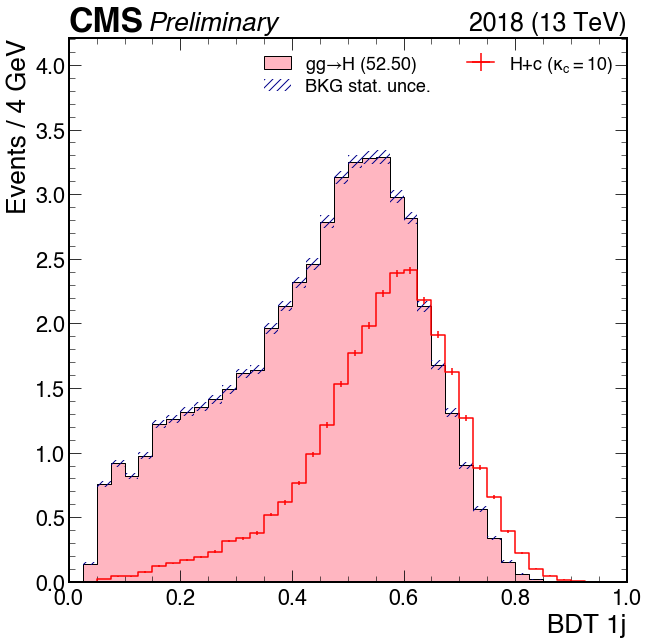

In [9]:
# make_plot(title='ZZMass_wide', nbin=282, xmin=72, xmax=1200, content_expr='df.mass4l', selection_expr=selection_dict['4e'],
#     do_flv_mode=True,
#     do_coffea=True, store_plot=False,
#     coffea_run_fileset=['ZX'], coffea_kwargs={'do_reco': True},
#     xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 4 GeV', custom_command="ax.set_xscale('log'); ax.set_xticks([80, 100, 200, 300, 400, 500, 700, 1000]); ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())")

# make_plot(title='jet_pt', nbin=40, xmin=0, xmax=200, content_expr='dfext.jet_cand.pt', selection_expr="ak.num(dfext.cleaned_jet) > 0",
#     do_flv_mode=False,
#     do_coffea=True, store_plot=False,
#     coffea_run_fileset=['HC_4FSFxFx', 'HC_4FS', 'HC_3FS'], coffea_kwargs={'do_reco': True},
#     xlabel=r'jet pT [GeV]', ylabel='Events / 4 GeV')

# make_plot(title='njet', nbin=10, xmin=0, xmax=10, content_expr='ak.num(dfext.cleaned_jet)', selection_expr=None,
#     do_flv_mode=False,
#     do_coffea=True, store_plot=False,
#     coffea_run_fileset=['HC_4FSFxFx', 'HC_4FS', 'HC_3FS'], coffea_kwargs={'do_reco': True},
#     xlabel=r'N(jet)', ylabel='Events / bin')

# make_plot(title='bdt_0j', nbin=40, xmin=0., xmax=1., content_expr='ak.fill_none(dfext.bdt_0j, -1)', selection_expr="ak.num(dfext.cleaned_jet) == 0", do_flv_mode=False,
#     do_coffea=True, store_plot=False, coffea_run_fileset=['ggH', 'HC_4FSFxFx'], coffea_kwargs={'do_reco': True, 'do_bdt_infer': True},
#     xlabel=r'BDT 0j', ylabel='Events / 4 GeV')

# make_plot(title='bdt_1j', nbin=40, xmin=0., xmax=1., content_expr='ak.fill_none(dfext.bdt_1j, -1)', selection_expr="ak.num(dfext.cleaned_jet) > 0", do_flv_mode=False,
#     do_coffea=True, store_plot=False, coffea_run_fileset=['ggH', 'HC_4FSFxFx'], coffea_kwargs={'do_reco': True, 'do_bdt_infer': True},
#     xlabel=r'BDT 1j', ylabel='Events / 4 GeV')

# make_plot(title='ZZMass_wide', nbin=30, xmin=-2, xmax=2, content_expr='np.log(ak.max(dfext.cleaned_sv.mass, axis=1))', selection_expr="ak.num(dfext.cleaned_sv) > 0", do_flv_mode=True,
#     do_coffea=True, store_plot=False, coffea_run_fileset=['ggH'], coffea_kwargs={'do_reco': True},
#     xlabel=r'ParticleNet CvsL', ylabel='Events / 4 GeV')
